In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
from IPython.display import clear_output
import torchsummary
import torch

import sys
sys.path.append('../..')

from vae import VAEModel, compute_fid_score
from rbm import RBM
from dbn import DBN
from load_data import load_mnist

# Load data

In [2]:
X_train, y_train, X_test, y_test = load_mnist(binarize=True)

# VAE - Image Generation

In [3]:
PATH = './vae_fid_scores.pkl'

def load_dict(path=PATH):
    with open(path, 'rb') as handle:
        d = pickle.load(handle)
    return d

def save_dict(d, path=PATH):
    with open(path, 'wb') as handle:
        pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [4]:
### Load and sort the dictionary of results ###

dict_results = load_dict()
sorted_values = sorted(dict_results.items(), key=lambda item: item[1])  # Sort by the second element (value)
dict_results = dict(sorted_values)

In [5]:
best_parameters = list(dict_results.keys())[0]
beta = float(best_parameters.split(',')[0])
latent_dim = int(best_parameters.split(',')[1])
alpha_lrelu = float(best_parameters.split(',')[2])
print(f'Beta: {beta}, latent dimension: {latent_dim}, leaky_relu scope: {alpha_lrelu}')

Beta: 0.5, latent dimension: 2, leaky_relu scope: 0.2


In [6]:
vae_model = VAEModel(latent_dim=latent_dim, beta=beta, alpha_lrelu=alpha_lrelu)

In [7]:
print('Encoder Architecture')
torchsummary.summary(vae_model.encoder, input_size=X_train.shape)

Encoder Architecture
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1           [-1, 60000, 512]         401,920
            Linear-2           [-1, 60000, 256]         131,328
            Linear-3             [-1, 60000, 4]           1,028
Total params: 534,276
Trainable params: 534,276
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 179.44
Forward/backward pass size (MB): 353.39
Params size (MB): 2.04
Estimated Total Size (MB): 534.88
----------------------------------------------------------------


In [8]:
print('Decoder Architecture')
torchsummary.summary(vae_model.decoder, input_size=(len(X_train), 2))

Decoder Architecture
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1           [-1, 60000, 256]             768
            Linear-2           [-1, 60000, 512]         131,584
            Linear-3           [-1, 60000, 784]         402,192
Total params: 534,544
Trainable params: 534,544
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/backward pass size (MB): 710.45
Params size (MB): 2.04
Estimated Total Size (MB): 712.95
----------------------------------------------------------------


In [9]:
nb_params_vae = 0
for param in vae_model.parameters():
    nb_params_vae += np.prod(param.size())

print(f"Nb parameters for VAE: {nb_params_vae:,}")

Nb parameters for VAE: 1,068,820


In [ ]:
_ = vae_model.train_vae(X_train, 5000, learning_rate=3e-6, batch_size=256, print_error_every=10, patience=50)

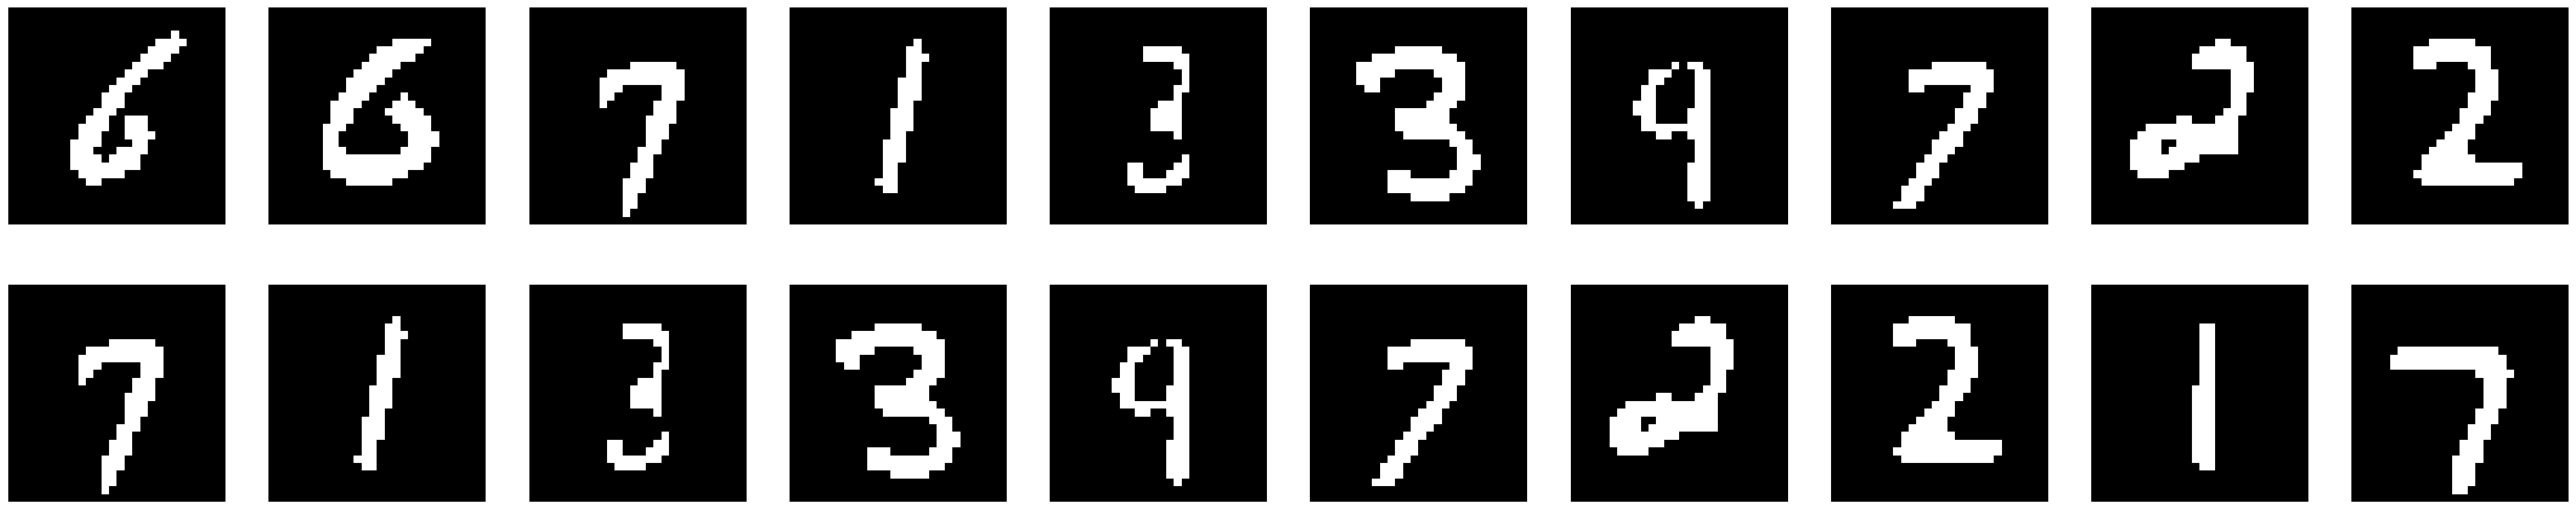

In [19]:
vae_gen = vae_model.generate_data()

In [12]:
vae_fid_score = list(dict_results.values())[0]
print(f"FID score with VAE: {vae_fid_score:.4f}")

FID score with VAE: 895.4239


# DBN

In [3]:
def compute_params_rbm(rbm):
    return rbm.a.shape[0] + rbm.b.shape[0] + np.prod(rbm.W.shape)

In [4]:
dbn_model = DBN(X=X_train, L=5, qs=[128, 512, 784, 512, 256], use_adam=True)

In [5]:
nb_params_dbn = 0
for rbm in dbn_model.rbms:
    nb_params_dbn += compute_params_rbm(rbm)

print(f"nb parameters for DBN: {nb_params_dbn:,}")

nb parameters for DBN: 1,104,688


In [6]:
try:
    dbn_model.load_weights("./weights/dbn_cmp_vae.pkl")
except:
    dbn_model.train_DBN(epochs=300, learning_rate=3e-4, batch_size=128, print_error_every=10)

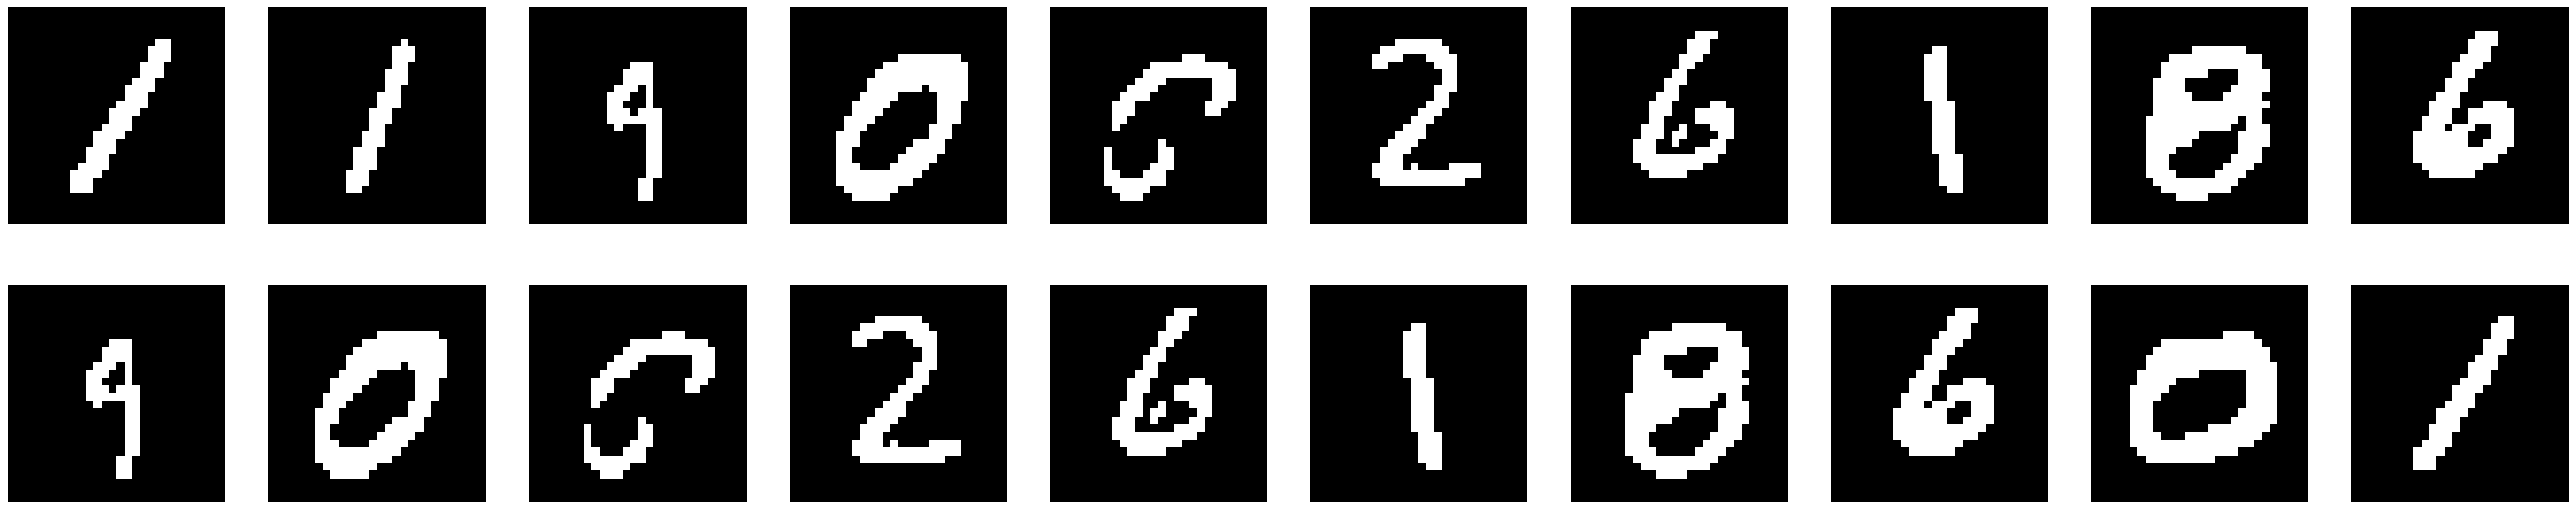

In [13]:
_ = dbn_model.generer_image_DBN(num_samples=20, gibbs_steps=200, ncols=10, image_size=(28, 28))

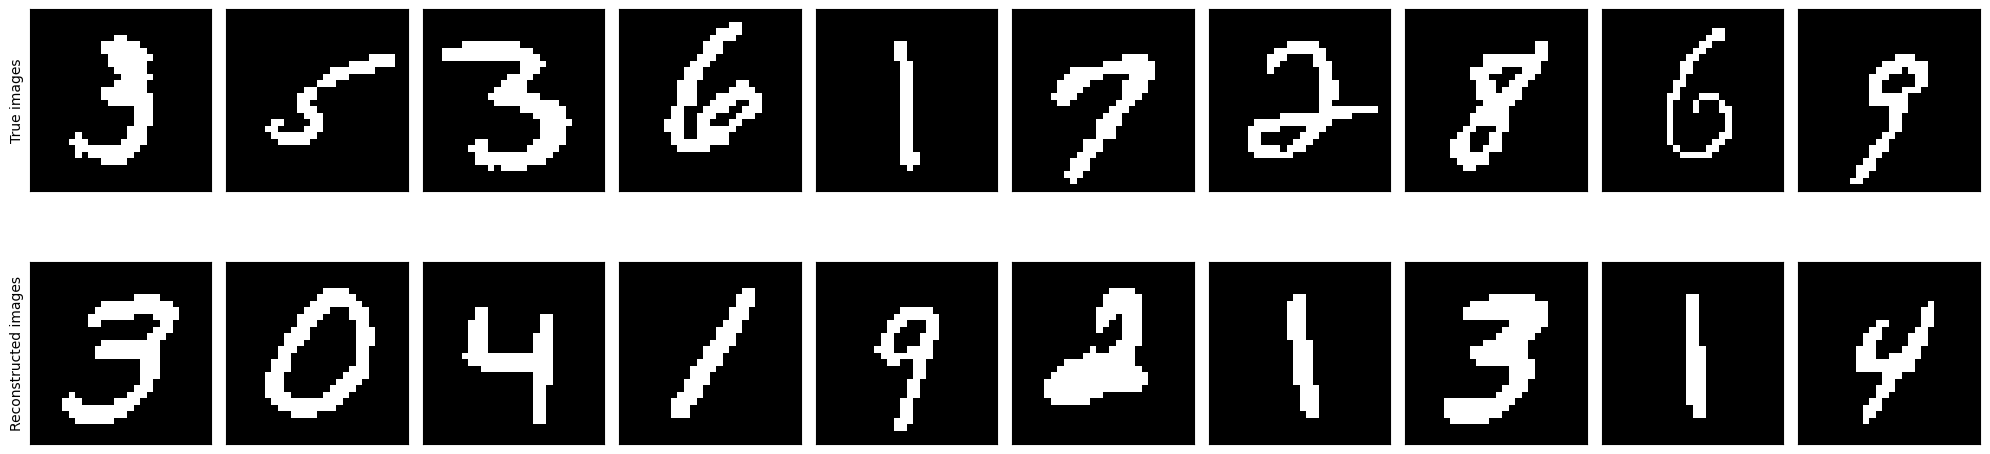

In [9]:
##### RECONSTRUCT IMAGES ######
h_L = X_train[:10]
for rbm in dbn_model.rbms:
    h_L, _ = rbm.entree_sortie_RBM(h_L)

top_rbm = dbn_model.rbms[-1]
for _ in range(200):
    h, _ = top_rbm.sortie_entree_RBM(h_L)
    h_L, _ = top_rbm.entree_sortie_RBM(h)

for rbm in reversed(dbn_model.rbms[:-1]):
    h, _ = rbm.sortie_entree_RBM(h)

h = np.where(h > 0.5, 1, 0)

fig, axs = plt.subplots(2, 10, figsize=(20, 6))
for j in range(10):
    axs[0, j].imshow(X_train[10:20][j].reshape(28, 28), cmap='gray')
    axs[0, j].set_xticks([])
    axs[0, j].set_yticks([])
    if j == 0:
        axs[0, j].set_ylabel('True images')

    axs[1, j].imshow(h[j].reshape(28, 28), cmap='gray')
    axs[1, j].set_xticks([])
    axs[1, j].set_yticks([])
    if j == 0:
        axs[1, j].set_ylabel('Reconstructed images')
plt.tight_layout()

In [16]:
dbn_generated_images = dbn_model.generer_image_DBN(num_samples=len(X_test[:5000]), gibbs_steps=200, plot_=False)
dbn_fid_score = compute_fid_score(X_test[:5000], dbn_generated_images, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print(f"FID score with DBN: {dbn_fid_score:.4f}")

FID score with DBN: 965.4677


In [7]:
dbn_model.save_weights(path='./weights/dbn_cmp_vae')

# RBM

In [4]:
rbm_model = RBM(X=X_train, q=784+512+128, use_adam=False)
## The RBM with to many parameters is extremely long to train, so much so that it makes it impossible to combine its training with Adam

nb_params_rbm = compute_params_rbm(rbm_model)
print(f"nb parameters for RBM: {nb_params_rbm:,}")

nb parameters for RBM: 1,118,624


In [5]:
try:
    rbm_model.load_weights("./weights/rbm_cmp_vae.pkl")
except:
    _ = rbm_model.train_RBM(1000, learning_rate=3e-4, batch_size=256, plot_errors=True, print_error_every=10, save_every=100, save_path='./rbm_train/rbm')

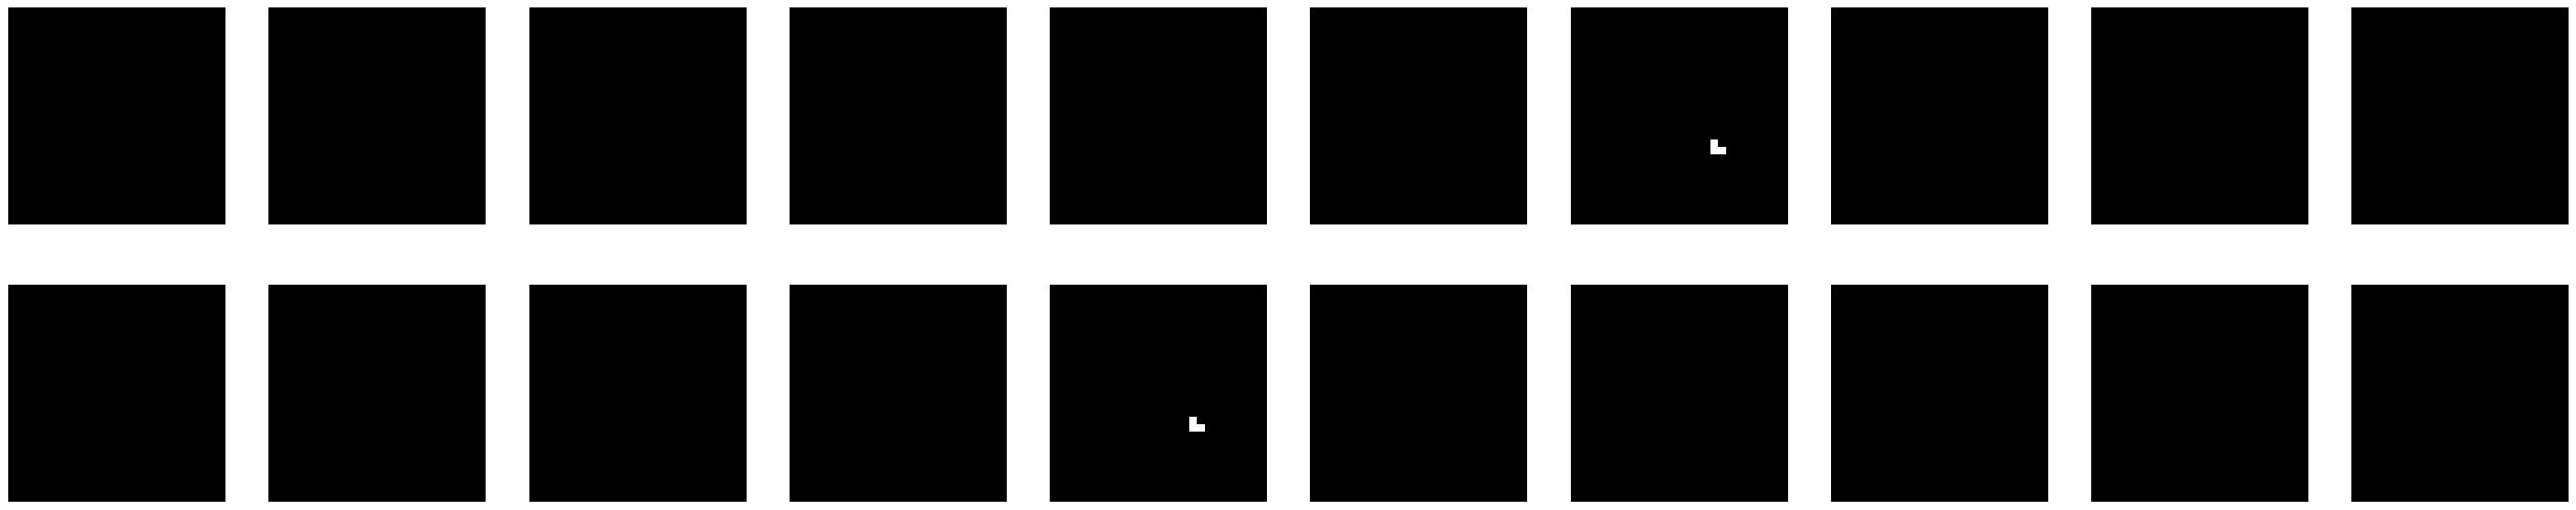

In [6]:
_ = rbm_model.generer_image_RBM(nb_step_gibbs=2000, nb_to_generate=20, ncols=10, image_size=(28, 28))

100%|██████████| 100/100 [00:00<00:00, 143.80it/s]


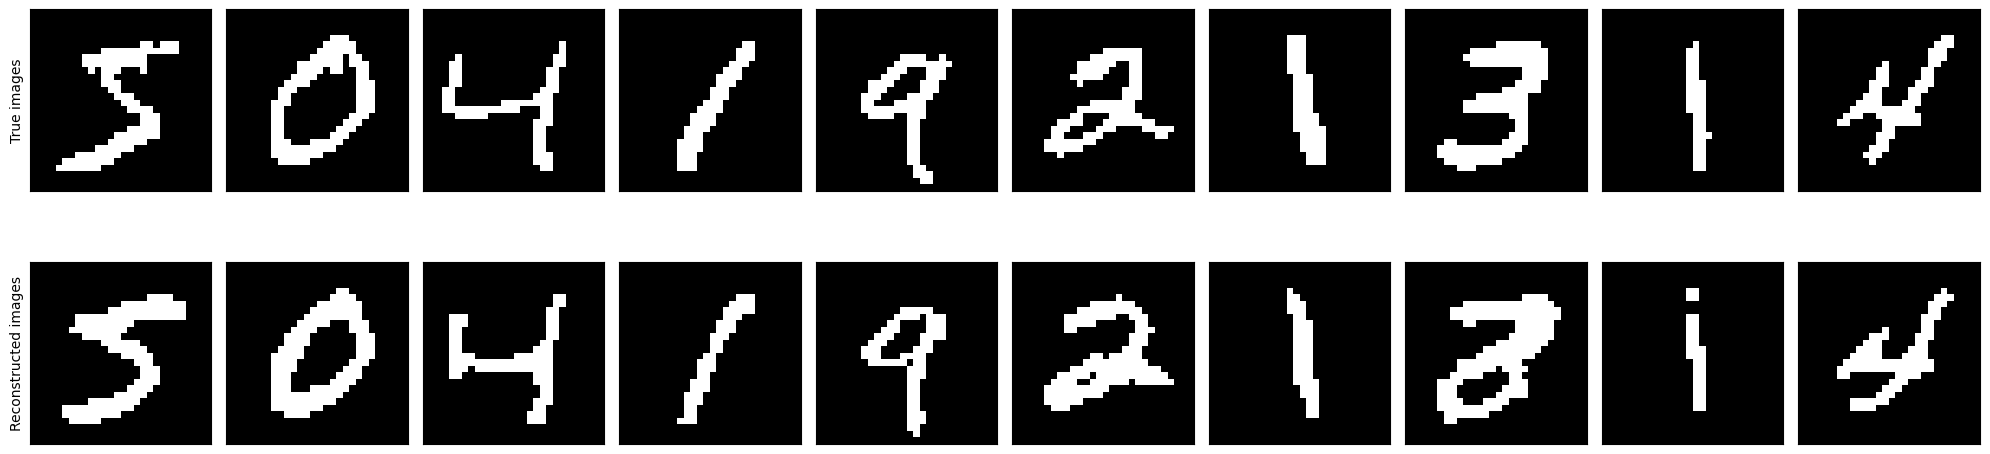

In [7]:
##### RECONSTRUCT IMAGES ######
X = X_train[:10]
for _ in tqdm(range(100)):
    _, h = rbm_model.entree_sortie_RBM(X)
    _, X = rbm_model.sortie_entree_RBM(h)

fig, axs = plt.subplots(2, 10, figsize=(20, 6))
for j in range(10):
    axs[0, j].imshow(X_train[j].reshape(28, 28), cmap='gray')
    axs[0, j].set_xticks([])
    axs[0, j].set_yticks([])
    if j == 0:
        axs[0, j].set_ylabel('True images')

    axs[1, j].imshow(X[j].reshape(28, 28), cmap='gray')
    axs[1, j].set_xticks([])
    axs[1, j].set_yticks([])
    if j == 0:
        axs[1, j].set_ylabel('Reconstructed images')
plt.tight_layout()

In [12]:
_, rbm_generated_images = rbm_model.generer_image_RBM(nb_step_gibbs=200, nb_to_generate=len(X_test[:5000]), ncols=10, plot_=False)
rbm_fid_score = compute_fid_score(X_test[:5000], rbm_generated_images, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print(f"FID score with RBM: {rbm_fid_score:.4f}")

FID score with RBM: 720.8833


In [13]:
rbm_model.save_weights(path='./weights/rbm_cmp_vae')

## RBM model with fewer parameters

In [7]:
## We can see that the RBM model with a number of parameters that matches that of the VAE or DBN is unable to efficiently train and thus cannot generate any new image
## We'll then try to train an RBM model with fewer (much) fewer parameters, even if it does not match the previous models

In [13]:
rbm_model_few_params = RBM(X=X_train, q=512, use_adam=False)

nb_params_rbm_few_params = compute_params_rbm(rbm_model_few_params)
print(f"nb parameters for RBM: {nb_params_rbm_few_params:,}")

nb parameters for RBM: 402,704


Epoch 0: error = 0.065
Epoch 10: error = 0.0391
Epoch 20: error = 0.033
Epoch 30: error = 0.0299
Epoch 40: error = 0.028
Epoch 50: error = 0.0266
Epoch 60: error = 0.0255
Epoch 70: error = 0.0246
Epoch 80: error = 0.0239
Epoch 90: error = 0.0233
Epoch 100: error = 0.0228
Epoch 110: error = 0.0223
Epoch 120: error = 0.0219
Epoch 130: error = 0.0215
Epoch 140: error = 0.0212
Epoch 150: error = 0.0209
Epoch 160: error = 0.0207
Epoch 170: error = 0.0204
Epoch 180: error = 0.0202
Epoch 190: error = 0.02
Epoch 200: error = 0.0198
Epoch 210: error = 0.0196
Epoch 220: error = 0.0194
Epoch 230: error = 0.0192
Epoch 240: error = 0.0191
Epoch 250: error = 0.0189
Epoch 260: error = 0.0188
Epoch 270: error = 0.0187
Epoch 280: error = 0.0185
Epoch 290: error = 0.0184
Epoch 300: error = 0.0183
Epoch 310: error = 0.0182
Epoch 320: error = 0.0181
Epoch 330: error = 0.018
Epoch 340: error = 0.0179
Epoch 350: error = 0.0178
Epoch 360: error = 0.0177
Epoch 370: error = 0.0176
Epoch 380: error = 0.0176
Epo

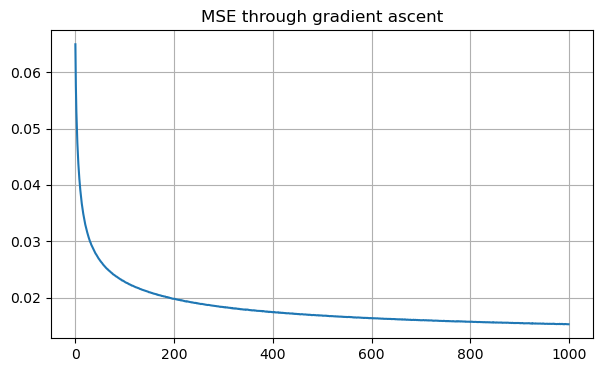

In [17]:
try:
    rbm_model_few_params.load_weights("./weights/rbm_few_params_cmp_vae.pkl")
except:
    _ = rbm_model_few_params.train_RBM(1000, learning_rate=3e-4, batch_size=256, plot_errors=True, print_error_every=10)
    rbm_model_few_params.save_weights(path='./rbm_few_params_cmp_vae')

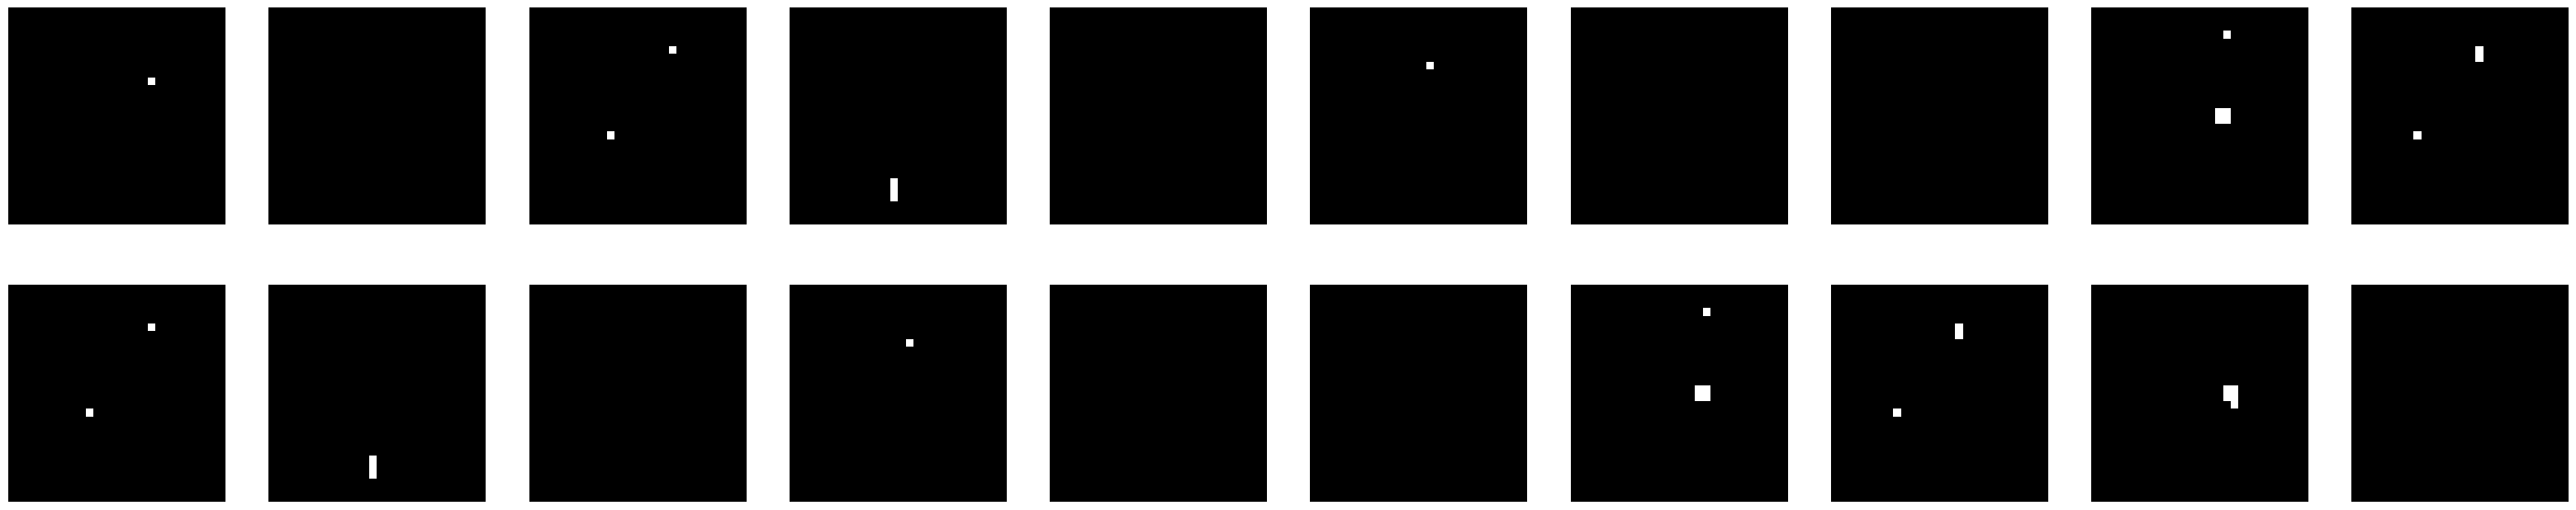

In [23]:
_ = rbm_model_few_params.generer_image_RBM(nb_step_gibbs=200, nb_to_generate=20, ncols=10, image_size=(28, 28))

In [24]:
_, rbm_few_params_generated_images = rbm_model_few_params.generer_image_RBM(nb_step_gibbs=200, nb_to_generate=len(X_test[:5000]), ncols=10, plot_=False)
rbm_few_params_fid_score = compute_fid_score(X_test[:5000], rbm_few_params_generated_images, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print(f"FID score with RBM: {rbm_few_params_fid_score:.4f}")

FID score with RBM: 908.0366
